Implementing FastAI’s ULMFiT to make a multi-class text classifier which we then use to predict the Conditions that a research is working on.

In [0]:
#Importing clinical trials data.
import pandas as pd

#We processed the clinical trials dataset and extracted the Title column and Conditions labels into a CSV file to use it for the model building
mydata = pd.read_csv('Clinical_data.csv')
mydata

,label,text
0,1102,Positive Airway Pressure for the Treatment of ...
1,1117,Understanding and Developing a Network-based S...
2,11,An Internet-Delivered Mind-Body Program for Re...
3,1102,"A Phase 1/2 Study of MPH966, an Oral Neutrophi..."
4,1102,Vertebrobasilar Flow Evaluation and Risk of Tr...
...,...,...
4987,11,"A Phase II Study of Cytoreduction, Gastrectomy..."
4988,11,Next Generation Sequencing of Esophageal Cytol...
4989,11,Predicting Analgesic Response to Acupuncture: ...
4990,1117,Innovative Incentive Strategies for Sustainabl...


In the code block below we remove those rows whose classes have insufficient numbers to be able to split by SKlearns split function validly.

In [0]:
a = mydata[mydata.Class != 1302]
b = a[a.Class != 1303]
c = b[b.Class != 1402]
d = c[c.Class != 1602]
e = d[d.Class != 1608]
f = e[e.Class != 10]
g = f[f.Class != 16]
h = g[g.Class != 912]
h

,Unnamed: 0,Title,Class
0,0,Positive Airway Pressure for the Treatment of ...,1102
1,1,Understanding and Developing a Network-based S...,1117
2,2,An Internet-Delivered Mind-Body Program for Re...,11
3,3,"A Phase 1/2 Study of MPH966, an Oral Neutrophi...",1102
4,4,Vertebrobasilar Flow Evaluation and Risk of Tr...,1102
...,...,...,...
4995,4995,"A Phase II Study of Cytoreduction, Gastrectomy...",11
4996,4996,Next Generation Sequencing of Esophageal Cytol...,11
4997,4997,Predicting Analgesic Response to Acupuncture: ...,11
4998,4998,Innovative Incentive Strategies for Sustainabl...,1117


In [0]:
k = h.drop('Unnamed: 0',axis =1)
k

,Unnamed: 0,Title,Class
0,0,Positive Airway Pressure for the Treatment of ...,1102
1,1,Understanding and Developing a Network-based S...,1117
2,2,An Internet-Delivered Mind-Body Program for Re...,11
3,3,"A Phase 1/2 Study of MPH966, an Oral Neutrophi...",1102
4,4,Vertebrobasilar Flow Evaluation and Risk of Tr...,1102
...,...,...,...
4995,4995,"A Phase II Study of Cytoreduction, Gastrectomy...",11
4996,4996,Next Generation Sequencing of Esophageal Cytol...,11
4997,4997,Predicting Analgesic Response to Acupuncture: ...,11
4998,4998,Innovative Incentive Strategies for Sustainabl...,1117


Here we split the data into train and test data sets

In [0]:

from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(mydata, stratify = mydata['label'], test_size = 0.3)
df_trn.shape, df_val.shape

((3494, 2), (1498, 2))

In [0]:
from fastai.text import *
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [0]:

#Saving the language model and classifier model to load them again
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')
data_lm = load_data('./', 'data_lm_export.pkl')
data_clas = load_data('./', 'data_clas_export.pkl', bs=64)



In [0]:
#build model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 7.59E-02


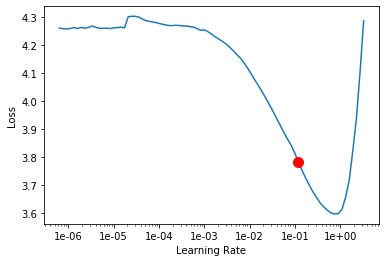

In [0]:
#finding optimal learning rate

learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
#training the model for 2 epochs
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.234430,2.656528,0.509801,03:51
1,2.716439,2.505202,0.529038,03:51


In [0]:
#unfreezing all layers

learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.125705,2.405598,0.537013,06:00
1,1.991692,2.388434,0.544318,05:58


In [0]:
learn.save_encoder('ft_enc')

In [0]:
#passing the input data and drop rate
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [0]:
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 9.12E-02


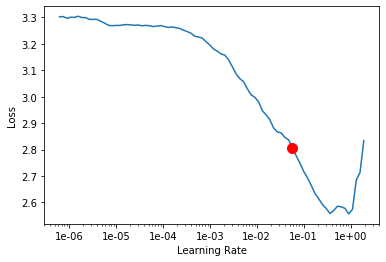

In [0]:
#Finding optimal learning rate when the layers are unfreezed
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.776764,1.445208,0.602136,02:21
1,1.450484,1.187839,0.647530,02:20


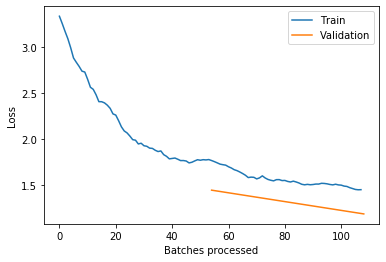

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.256401,1.188170,0.646863,02:45
1,1.245692,1.144494,0.654873,02:57
2,1.187399,1.118942,0.660881,02:58
3,1.118170,1.108634,0.664219,02:47


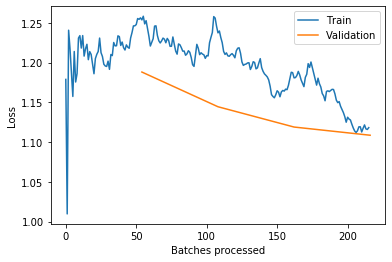

In [0]:

learn.recorder.plot_losses()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.098970,1.098613,0.664219,06:47
1,1.105231,1.084817,0.666889,06:29
2,1.030336,1.077331,0.670227,07:26
3,0.984499,1.069304,0.674900,06:41


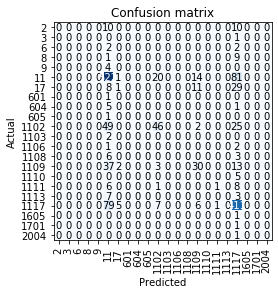

In [0]:
#predictions on unseen test data
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
#plotting confusion matrix
interp.plot_confusion_matrix()

In [0]:
learn.predict("Acute Effects of Cannabis on Cognition and Mobility in Older HIV-infected and Uninfected Women")

(Category 1117,
 tensor(18),
 tensor([3.1595e-03, 1.2522e-05, 3.5344e-04, 1.1227e-03, 1.3492e-04, 1.0847e-01,
         1.4316e-02, 1.7428e-05, 4.8263e-04, 3.5931e-05, 5.9619e-03, 1.5888e-04,
         1.8080e-04, 4.2520e-03, 4.0114e-03, 1.9876e-03, 3.3594e-03, 6.1064e-04,
         8.5122e-01, 5.6862e-05, 7.6992e-05, 1.7380e-05]))

***SECOND MODEL***

**Prediction using Universal Sentence Encoder**

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install seaborn

In [0]:
#importing required libraries
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
embed = hub.Module(module_url)

In [0]:
#importing the processed data
mydata = pd.read_csv('not_final3.csv')
mydata = mydata.drop('Unnamed: 0',axis =1)
mydata

,label,text
0,1102,Positive Airway Pressure for the Treatment of ...
1,1117,Understanding and Developing a Network-based S...
2,11,An Internet-Delivered Mind-Body Program for Re...
3,1102,"A Phase 1/2 Study of MPH966, an Oral Neutrophi..."
4,1102,Vertebrobasilar Flow Evaluation and Risk of Tr...
...,...,...
23884,11,Network and Contingency Management for Alcohol...
23885,1102,Genetic Susceptibility TO Ozone-induced Bronch...
23886,1102,"Safety Study To Determine the Effect of a 10,0..."
23887,1117,Biospecimen Resource for Familial Pancreas Res...


In [0]:
#split the data into train and test
from sklearn.model_selection import train_test_split 

X_train , X_test  = train_test_split(mydata , stratify=mydata.label,test_size = .20 , )


In [0]:
#Explicitly cast the input as a string
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:
#Building the model with 2 layers, relu and softmax activation functions

input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(17, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                4369      
Total params: 135,697
Trainable params: 135,697
Non-trainable params: 0
_________________________________________________________________


In [0]:
#1-hot encoding our train classes
train_text = X_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(X_train['label']), dtype = np.int8)

In [0]:
#1-hot encoding our test classes
test_text = X_test['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(X_test['label']), dtype = np.int8)

In [0]:
#This only train and save our Keras layers not the embed module' weights.
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_data=(test_text, test_label),
            epochs=10,
            batch_size=32)
  model.save_weights('./model.h5')

Train on 19111 samples, validate on 4778 samples
Epoch 1/10
19111/19111 [==============================] - 459s 24ms/step - loss: 1.1742 - acc: 0.6280 - val_loss: 1.0417 - val_acc: 0.6547
Epoch 2/10
19111/19111 [==============================] - 453s 24ms/step - loss: 1.0121 - acc: 0.6583 - val_loss: 0.9880 - val_acc: 0.6664
Epoch 3/10
19111/19111 [==============================] - 452s 24ms/step - loss: 0.9719 - acc: 0.6658 - val_loss: 0.9597 - val_acc: 0.6674
Epoch 4/10
19111/19111 [==============================] - 457s 24ms/step - loss: 0.9478 - acc: 0.6692 - val_loss: 0.9484 - val_acc: 0.6741
Epoch 5/10
19111/19111 [==============================] - 461s 24ms/step - loss: 0.9285 - acc: 0.6733 - val_loss: 0.9415 - val_acc: 0.6756
Epoch 6/10
19111/19111 [==============================] - 462s 24ms/step - loss: 0.9100 - acc: 0.6823 - val_loss: 0.9309 - val_acc: 0.6806
Epoch 7/10
19111/19111 [==============================] - 464s 24ms/step - loss: 0.8954 - acc: 0.6853 - val_loss: 0.9

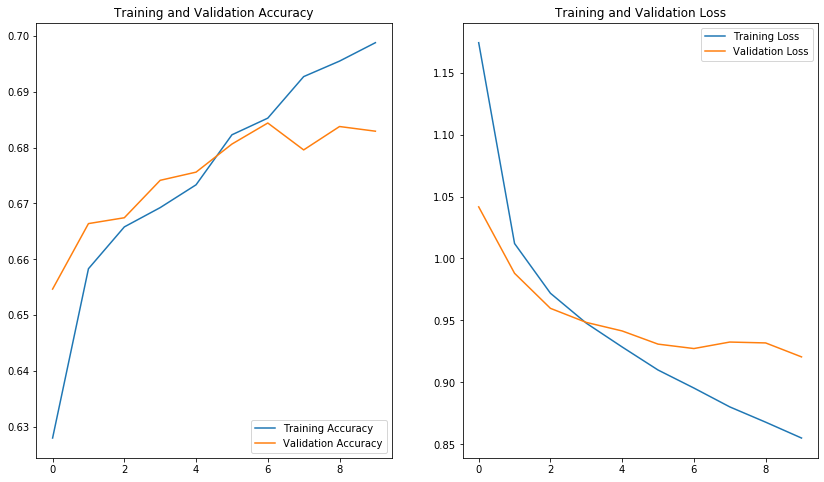

In [0]:
#VISUALIZATION OF ACCURACY AFTER AUGMENTATION
import matplotlib.pyplot as plt

def acc_loss_plot(history, epochs):
    epochs = 10
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    #training and validation accuracy curve

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #training and validation loss curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
acc_loss_plot(history , 20)

In [0]:
new_text = ["Diet-induced Modification of Sweet Taste Perception and Preference", "Endometrial Biopsy Biomarkers for Prediction of IVF Outcomes", "Behavioral Pharmacology of Cannabis and Nicotine"]
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

In [0]:
#predictions on unseen test data

categories = X_train['label'].tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

[1117, 1117, 11]